# Transfer Learning
A study into the effects of whether training from scratch or using transfer learning was better from a practioner's point of view, found transfer learning to be far more beneficial in terms of cost and time even if the downstream data of interests appears to be weakly related to the data used for pre-training
- each of the PyTorch domain libraries (`torchvision`, `torchtext`...) has pretrained models (`torchvision.models`...)
- HuggingFace
- `timm` has CV models in PyTorch. compared to `torchvision.models` it contains newer models


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Get the going_modular scripts
print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4135, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 4135 (delta 42), reused 76 (delta 26), pack-reused 4027 (from 1)
Receiving objects: 100% (4135/4135), 650.98 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (2407/2407), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

### 1. Create Datasets and DataLoaders
Since we'are using a pretrained model, custom data going into the model must be prepared in the same way as the original training data. Now this process is automatized, but prior to `torchvision` v0.13+ to create a transform for a pretrained model in `torchvision.models`, the documentation required:
- all pre-trained models expect input images normalized in the same way: mini-batches of 3-channel RGB images of shape (3xHxW) where H and W should be at least 224
- the images have to be loaded in a range of [0,1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

auto_transforms is easy to use since we don't have to create from scratch the pipeline and we're sure data to be in the correct format. However this comes with a lack of customization

In [7]:
# @title Manual-transform: create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eaa710fd2a0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# @title Auto-transform: get transforms used during training

# Say EfficientNet_B0_Weights is the chosen model architecture
# DEFAULT means the best available weigts (= best performance)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get the transforms associated with the weights --> get the transforms applied on the data on which the model was trained
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

EfficientNet_B1 is a larger and more performing model than the 0 and so on...<br> For example a company uses EfficientNet_B2 to learn a representation of the road for self-driving cars

### 2. Load a pretrained model

In [11]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.4MB/s]


Transfer learning techniques:
- **feature extraction**
    - uses the representation learned by the pre-trained network to extract meaningful features and create a new output layer. Only the latter will be trained
    - useful when the target dataset is similar to the source, same for the task, and the pre-trained model already has a very powerful feature representations
    - for small dataset this limits the risk of overfitting since most of the weights are frozen
- **fine tuning**
    - modify the output layer and selectively unfreeze some or all of the layer of the pre-trained model

EfficientNet has 3 main parts:
1. features - series of convolutional layers + activation layers to learn the different features of images in a representation
2. avgpool - takes the average of the output of the features layers and turns it into a feature vector. Since the input is (32, 1280, 7, 7) it uses a (7,7) kernel to output (32, 1280, 1 ,1)
3. classifier - output a vector with the same dimensionality as the number of output classes. Its standard value is `out_features = 3` but for our task we'll substitute it with `out_features = 3`

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3. Train the model

In [12]:
# @title Freeze weights

"""
In order to freeze weights it's sufficient to set the attribute requires_grad of the parameter = False
So Pytorch won't track gradient updates and these parameters won't be touched by the optimizer during training
"""

# Freeze all base layers in the "features" section of the model
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [16]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [19]:
model.classifier.state_dict()

OrderedDict([('1.weight',
              tensor([[ 0.0214,  0.0232, -0.0065,  ...,  0.0154,  0.0047,  0.0092],
                      [-0.0202, -0.0070, -0.0027,  ...,  0.0113,  0.0120, -0.0009],
                      [-0.0141,  0.0195,  0.0185,  ...,  0.0133,  0.0073, -0.0010]])),
             ('1.bias', tensor([-0.0236,  0.0091,  0.0181]))])

In [24]:
# @title Create Sections in PyTorch models

"""
Each model is a nn.Module, but also layers are nn.Module. This means that a layer can be seen as a section
organized for a part of the job: features for features extraction, avgpool for average pooling...
"""

import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Example of a model using ConvBlock
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.block1 = ConvBlock(in_channels=3, out_channels=2)
        self.block2 = ConvBlock(in_channels=16, out_channels=3)
        self.fc = nn.Linear(in_features=3*32*32, out_features=10)  # Example input size

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the model
model = MyModel()

model.block1.state_dict()

OrderedDict([('conv.weight',
              tensor([[[[-0.0390, -0.1584,  0.1159],
                        [ 0.1191,  0.0623, -0.1637],
                        [-0.1257, -0.0229,  0.1104]],
              
                       [[-0.1601,  0.0646, -0.0781],
                        [ 0.0327,  0.0084, -0.0437],
                        [ 0.1529, -0.0858, -0.0568]],
              
                       [[ 0.1711, -0.1293, -0.1699],
                        [-0.0693,  0.1891,  0.0780],
                        [ 0.0435,  0.0495,  0.1487]]],
              
              
                      [[[ 0.0056,  0.0211,  0.0217],
                        [-0.0145, -0.1193, -0.1485],
                        [ 0.1145,  0.1000, -0.0790]],
              
                       [[ 0.1574,  0.1273, -0.0416],
                        [-0.1449, -0.0169, -0.1277],
                        [ 0.1437,  0.1031,  0.0455]],
              
                       [[-0.1382,  0.1236,  0.0417],
                        [-0

In [14]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 10.116 seconds


### 4. Predictions from test set

In [16]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device) -> None:

    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            # Resizing should be done before converting the image to a tensor because the
            # Resize transform operates on PIL Image objects, not on tensor objects
            transforms.Resize(image_size),
            # Converts the image to a tensor with values scaled to [0.0, 1.0] and rearrange
            # image dimensions from (h, w, c) to (c, h, w)
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])])

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

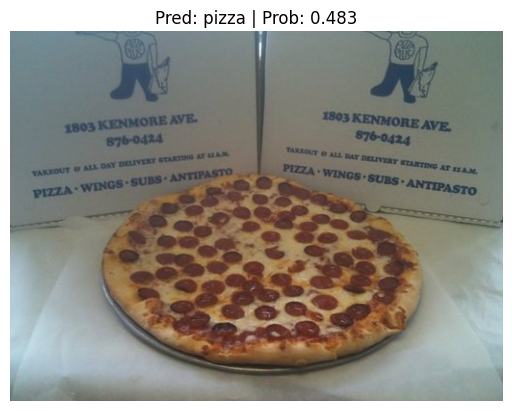

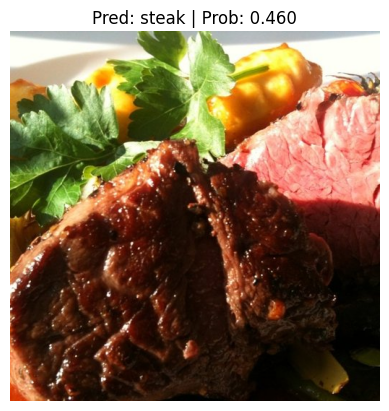

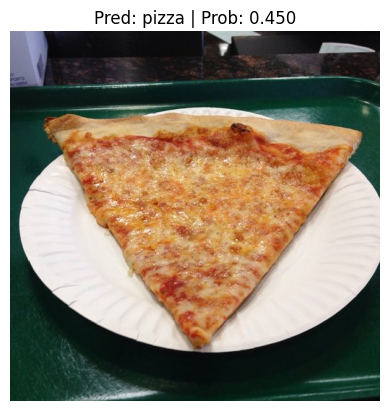

In [17]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))